In [1]:
!pip install --upgrade quantecon

Requirement already up-to-date: quantecon in c:\anaconda\lib\site-packages (0.4.6)


In [2]:
import quantecon as qe
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ψ = (0.3, 0.7) # probabilities over {0, 1}
cdf = np.cumsum(ψ) # convert into cummulative distribution
qe.random.draw(cdf, 5) # generate 5 independent draws from ψ

array([1, 1, 1, 1, 1])

In [4]:
def mc_sample_path(P, ψ_0=None, sample_size=1_000):
# set up
    P = np.asarray(P)
    X = np.empty(sample_size, dtype=int)
# Convert each row of P into a cdf
    n = len(P)
    P_dist = [np.cumsum(P[i, :]) for i in range(n)]
# draw initial state, defaulting to 0
    if ψ_0 is not None:
        X_0 = qe.random.draw(np.cumsum(ψ_0))
    else:
        X_0 = 0
# simulate
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P_dist[X[t]])
    return X

In [8]:
P = [[0.4, 0.6],
    [0.2, 0.8]]

In [9]:
X = mc_sample_path(P, ψ_0=[0.1, 0.9], sample_size=100_000)
np.mean(X == 0)

0.25136

In [10]:
from quantecon import MarkovChain
mc = qe.MarkovChain(P)
X = mc.simulate(ts_length=1_000_000)
np.mean(X == 0)

0.25022

In [11]:
%time mc_sample_path(P, sample_size=1_000_000)

Wall time: 1.95 s


array([0, 0, 0, ..., 1, 0, 1])

In [12]:
%time mc.simulate(ts_length=1_000_000)

Wall time: 69.1 ms


array([0, 1, 0, ..., 1, 1, 1])

In [13]:
mc = qe.MarkovChain(P, state_values=('unemployed', 'employed'))
mc.simulate(ts_length=4, init='employed')

array(['employed', 'unemployed', 'unemployed', 'employed'], dtype='<U10')

In [14]:
mc.simulate(ts_length=4, init='unemployed')

array(['unemployed', 'employed', 'employed', 'employed'], dtype='<U10')

In [15]:
mc.simulate(ts_length=4)

array(['employed', 'employed', 'employed', 'employed'], dtype='<U10')

In [16]:
mc.simulate_indices(ts_length=4)

array([1, 1, 1, 1])

In [17]:
P = [[0.9, 0.1, 0.0],
[0.4, 0.4, 0.2],
[0.1, 0.1, 0.8]]
mc = qe.MarkovChain(P, ('poor', 'middle', 'rich'))
mc.is_irreducible

True

In [18]:
P = [[1.0, 0.0, 0.0],
[0.1, 0.8, 0.1],
[0.0, 0.2, 0.8]]
mc = qe.MarkovChain(P, ('poor', 'middle', 'rich'))
mc.is_irreducible

False

In [19]:
mc.communication_classes

[array(['poor'], dtype='<U6'), array(['middle', 'rich'], dtype='<U6')]

In [20]:
P = [[0, 1, 0],
[0, 0, 1],
[1, 0, 0]]
mc = qe.MarkovChain(P)
mc.period

3

In [21]:
P = [[0.0, 1.0, 0.0, 0.0],
[0.5, 0.0, 0.5, 0.0],
[0.0, 0.5, 0.0, 0.5],
[0.0, 0.0, 1.0, 0.0]]
mc = qe.MarkovChain(P)
mc.period

2

In [22]:
mc.is_aperiodic

False

In [23]:
P = np.array([[0.4, 0.6],
[0.2, 0.8]])
ψ = (0.25, 0.75)
ψ @ P

array([0.25, 0.75])

In [24]:
P = [[0.4, 0.6],
[0.2, 0.8]]
mc = qe.MarkovChain(P)
mc.stationary_distributions

array([[0.25, 0.75]])

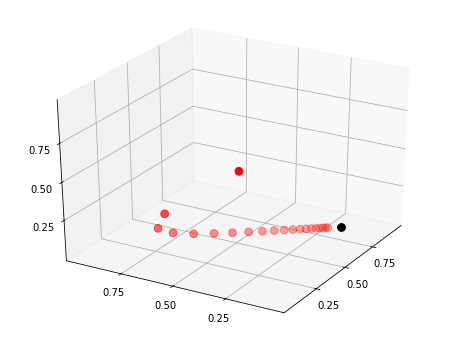

In [25]:
P = ((0.971, 0.029, 0.000),
(0.145, 0.778, 0.077),
(0.000, 0.508, 0.492))
P = np.array(P)
ψ = (0.0, 0.2, 0.8) # Initial condition
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1),
xticks=(0.25, 0.5, 0.75),
yticks=(0.25, 0.5, 0.75),
zticks=(0.25, 0.5, 0.75))
x_vals, y_vals, z_vals = [], [], []
for t in range(20):
    x_vals.append(ψ[0])
    y_vals.append(ψ[1])
    z_vals.append(ψ[2])
    ψ = ψ @ P
ax.scatter(x_vals, y_vals, z_vals, c='r', s=60)
ax.view_init(30, 210)
mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='k', s=60)
plt.show()

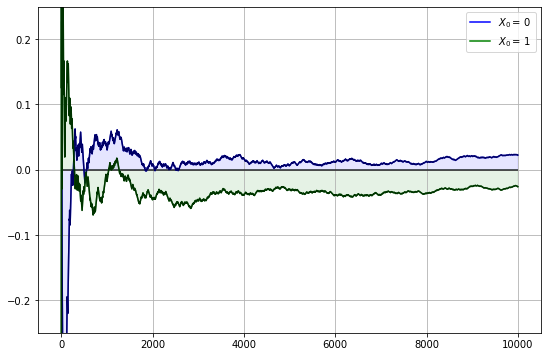

In [26]:
α = β = 0.1
N = 10000
p = β / (α + β)
P = ((1 - α, α), # Careful: P and p are distinct
( β, 1 - β))
P = np.array(P)
mc = MarkovChain(P)
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_ylim(-0.25, 0.25)
ax.grid()
ax.hlines(0, 0, N, lw=2, alpha=0.6) # Horizonal line at zero
for x0, col in ((0, 'blue'), (1, 'green')):
# Generate time series for worker that starts at x0
    X = mc.simulate(N, init=x0)
# Compute fraction of time spent unemployed, for each n
    X_bar = (X == 0).cumsum() / (1 + np.arange(N, dtype=float))
# Plot
    ax.fill_between(range(N), np.zeros(N), X_bar - p, color=col, alpha=0.1)
    ax.plot(X_bar - p, color=col, label=f'$X_0 = \, {x0} $')
# Overlay in black--make lines clearer
    ax.plot(X_bar - p, 'k-', alpha=0.6)
ax.legend(loc='upper right')
plt.show()